<a href="https://colab.research.google.com/github/Prasannajnaeyulu/Algorithms-And-DS/blob/main/10_NN_lab_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Chapter 10

# Lab: Deep Learning -- neural networks
In this section we  demonstrate how to fit the examples discussed
in the text. We use the `Python`  `torch` package, along with the
`pytorch_lightning` package which provides utilities to simplify
fitting and evaluating models.  This code can be impressively fast
with certain  special processors,  such as Apple’s new M1 chip. The package is well-structured, flexible, and will feel comfortable
to `Python`  users. A good companion is the site
[pytorch.org/tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html).
Much of our code is adapted from there, as well as the `pytorch_lightning` documentation. {The precise URLs at the time of writing are <https://pytorch.org/tutorials/beginner/basics/intro.html> and <https://pytorch-lightning.readthedocs.io/en/latest/>.}

We start with several standard imports that we have  seen before.

In [3]:
!pip install ISLP
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=6d1dd16db9cf6589256b3dc1c72a3d4ce43a1e1816699ee289d454eb71f378bf
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting un

### Torch-Specific Imports
There are a number of imports for `torch`. (These are not
included with `ISLP`, so must be installed separately.)
First we import the main library
and essential tools used to specify sequentially-structured networks.

In [4]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset


There are several other helper packages for `torch`. For instance,
the `torchmetrics` package has utilities to compute
various metrics to evaluate performance when fitting
a model. The `torchinfo` package provides a useful
summary of the layers of a model. We use the `read_image()`
function when loading test images in Section 10.9.4.

In [5]:
!pip install torchinfo

In [6]:
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary


The package `pytorch_lightning` is a somewhat higher-level
interface to `torch` that simplifies the specification and
fitting of
models by reducing the amount of boilerplate code needed
(compared to using `torch` alone).

In [7]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger


In order to reproduce results we use `seed_everything()`. We will also instruct `torch` to use deterministic algorithms
where possible.

In [8]:
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)


INFO:lightning_fabric.utilities.seed:Seed set to 0


We will use several datasets shipped with `torchvision` for our
examples: a pretrained network for image classification,
as well as some transforms used for preprocessing.

In [10]:
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

We have provided a few utilities in `ISLP` specifically for this lab.
The `SimpleDataModule` and `SimpleModule` are simple
versions of objects used in `pytorch_lightning`, the
high-level module for fitting `torch` models. Although more advanced
uses such as computing on graphical processing units (GPUs) and parallel data processing
are possible in this module, we will not be focusing much on these
in this lab. The `ErrorTracker` handles
collections of targets and predictions over each mini-batch
in the validation or test stage, allowing computation
of the metric over the entire validation or test data set.

In [11]:
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)


In addition we have included some helper
functions to load the
`IMDb` database, as well as a lookup that maps integers
to particular keys in the database. We’ve included
a slightly modified copy of the preprocessed
`IMDb` data from `keras`, a separate package
for fitting deep learning models. This saves us significant
preprocessing and allows us to focus on specifying and fitting
the models themselves.

In [12]:
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)


Finally, we introduce some utility imports  not directly related to
`torch`.
The `glob()` function from the `glob` module is used
to find all files matching wildcard characters, which we will use
in our example applying the `ResNet50` model
to some of our own images.
The `json` module will be used to load
a JSON file for looking up classes to identify the labels of the
pictures in the `ResNet50` example.

In [14]:
from glob import glob
import json

## Single Layer Network on Hitters Data
We start by fitting the models in Section 10.6 on the `Hitters` data.

In [15]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]


 We will fit two linear models (least squares  and lasso) and  compare their performance
to that of a neural network. For this comparison we will use mean absolute error on a validation dataset.
\begin{equation*}
\begin{split}
\mbox{MAE}(y,\hat{y}) = \frac{1}{n} \sum_{i=1}^n |y_i-\hat{y}_i|.
\end{split}
\end{equation*}
We set up the model matrix and the response.

In [16]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()


The `to_numpy()`  method above converts `pandas`
data frames or series to `numpy` arrays.
We do this because we will need to  use `sklearn` to fit the lasso model,
and it requires this conversion.
We also use  a linear regression method from `sklearn`, rather than the method
in Chapter~3 from `statsmodels`, to facilitate the comparisons.

We now split the data into test and training, fixing the random
state used by `sklearn` to do the split.

In [17]:
(X_train,
 X_test,
 Y_train,
 Y_test) = train_test_split(X,
                            Y,
                            test_size=1/3,
                            random_state=1)

### Linear Models
We fit the linear model and evaluate the test error directly.

In [18]:
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean()

259.7152883314631

Next we fit the lasso using `sklearn`. We are using
mean absolute error to select and evaluate a model, rather than mean squared error.
The specialized solver we used in Section 6.5.2 uses only mean squared error. So here, with a bit more work,  we create a cross-validation grid and perform the cross-validation directly.  

We encode a pipeline with two steps: we first normalize the features using a `StandardScaler()` transform,
and then fit the lasso without further normalization.

In [19]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler', scaler),
                                 ('lasso', lasso)])

We need to create a grid of values for $\lambda$. As is common practice,
we choose a grid of 100 values of $\lambda$, uniform on the log scale from `lam_max` down to  `0.01*lam_max`. Here  `lam_max` is the smallest value of
$\lambda$ with an  all-zero solution. This value equals the largest absolute inner-product between any predictor and the (centered) response. {The derivation of this result is beyond the scope of this book.}

In [23]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100))
             * lam_max}
print(param_grid)

{'alpha': array([255.65755026, 244.03752004, 232.94563812, 222.35789935,
       212.25138966, 202.60423642, 193.39556119, 184.60543446,
       176.21483255, 168.20559645, 160.5603925 , 153.26267486,
       146.29664975, 139.64724123, 133.3000586 , 127.24136521,
       121.45804878, 115.93759301, 110.66805048, 105.63801679,
       100.83660589,  96.25342653,  91.87855974,  87.7025374 ,
        83.71632172,  79.9112857 ,  76.27919443,  72.81218732,
        69.50276103,  66.34375328,  63.3283273 ,  60.44995709,
        57.70241324,  55.07974951,  52.57628988,  50.18661637,
        47.9055572 ,  45.72817569,  43.64975953,  41.66581059,
        39.7720352 ,  37.96433481,  36.23879721,  34.59168794,
        33.01944234,  31.51865773,  30.08608609,  28.71862704,
        27.41332112,  26.16734337,  24.97799723,  23.8427087 ,
        22.7590208 ,  21.72458818,  20.73717211,  19.79463564,
        18.8949389 ,  18.03613476,  17.2163646 ,  16.43385426,
        15.68691022,  14.97391594,  14.293328

Note that we had to transform the data first, since the scale of the variables impacts the choice of $\lambda$.
We now perform cross-validation using this sequence of $\lambda$ values.

In [21]:
cv = KFold(10,
           shuffle=True,
           random_state=1)
grid = GridSearchCV(lasso,
                    param_grid,
                    cv=cv,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train);

We extract the lasso model with best cross-validated mean absolute error, and evaluate its
performance on `X_test` and `Y_test`, which were not used in
cross-validation.

In [22]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

257.23820107995

This is similar to the results we got for the linear model fit by least squares. However, these results can vary a lot for different train/test splits; we encourage the reader to try a different seed in code block 12 and rerun the subsequent code up to this point.

### Specifying a Network: Classes and Inheritance
To fit the neural network, we first set up a model structure
that describes the network.
Doing so requires us to define new classes specific to the model we wish to fit.
Typically this is done in  `pytorch` by sub-classing a generic
representation of a network, which is the approach we take here.
Although this example is simple, we will go through the steps in some detail, since it will serve us well
for the more complex examples to follow.


In [25]:
class HittersModel(nn.Module):

    def __init__(self, input_size):
        super(HittersModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1))

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))


The `class` statement identifies the code chunk as a
declaration for a class `HittersModel`
that inherits from the  base class `nn.Module`. This base
class is ubiquitous in `torch` and represents the
mappings in the neural networks.

Indented beneath the `class` statement are the methods of this class:
in this case `__init__` and `forward`.  The `__init__` method is
called when an instance of the class is created as in the cell
below. In the methods, `self` always refers to an instance of the
class. In the `__init__` method, we have attached two objects to
`self` as attributes: `flatten` and `sequential`. These are used in
the `forward` method to describe the map that this module implements.

There is one additional line in the `__init__` method, which
is a call to
`super()`. This function allows subclasses (i.e. `HittersModel`)
to access methods of the class they inherit from. For example,
the class `nn.Module` has its own `__init__` method, which is different from
the `HittersModel.__init__()` method we’ve written above.
Using `super()` allows us to call the method of the base class. For
`torch` models, we will always be making this `super()` call as it is necessary
for the model to be properly interpreted by `torch`.

The object `nn.Module` has more methods than simply `__init__` and `forward`. These
methods are directly accessible to `HittersModel` instances because of this inheritance.
One such method we will see shortly is the `eval()` method, used
to disable dropout for when we want to evaluate the model on test data.

In [26]:
hit_model = HittersModel(X.shape[1])


The object `self.sequential` is a composition of four maps. The
first maps the 19 features of `Hitters` to 50 dimensions, introducing $50\times 19+50$ parameters
for the weights and *intercept*  of the map (often called the *bias*). This layer
is then mapped to a ReLU layer followed by a 40% dropout layer, and finally a
linear map down to 1 dimension, again with a bias. The total number of
trainable parameters is therefore $50\times 19+50+50+1=1051$.

    

The package `torchinfo` provides a `summary()` function that neatly summarizes
this information. We specify the size of the input and see the size
of each tensor as it passes through layers of the network.

In [27]:
summary(hit_model,
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

We have truncated the end of the output slightly, here and in subsequent uses.

We now need to transform our training data into a form accessible to `torch`.
The basic
datatype in `torch` is a `tensor`, which is very similar
to an `ndarray` from early chapters.
We also note here that `torch` typically
works with 32-bit (*single precision*)
rather than 64-bit (*double precision*) floating point numbers.
We therefore convert our data to `np.float32` before
forming the tensor.
The $X$ and $Y$ tensors are then arranged into a `Dataset`
recognized by `torch`
using `TensorDataset()`.

In [29]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

We do the same for the test data.

In [32]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)


Finally, this dataset is passed to a `DataLoader()` which ultimately
passes data into our network. While this may seem
like a lot of overhead, this structure is helpful for more
complex tasks where data may live on different machines,
or where data must be passed to a GPU.
We provide a helper function `SimpleDataModule()` in `ISLP` to make this task easier for
standard usage.
One of its arguments is `num_workers`, which indicates
how many processes we will use
for loading the data. For small
data like `Hitters` this will have little effect, but
it does provide an advantage for the `MNIST`  and `CIFAR100` examples below.
The `torch` package will inspect the process running and determine a
maximum number of workers. {This depends on the computing hardware and the number of cores available.} We’ve included a function
`rec_num_workers()` to compute this so we know how many
workers might be reasonable (here the max was 16).

In [33]:
max_num_workers = rec_num_workers()

The general training setup in `pytorch_lightning` involves
training, validation and test data. These are each
represented by different data loaders. During each epoch,
we run a training step to learn the model and a validation
step to track the error. The test data is typically
used at the end of training to evaluate the model.

In this case, as we had split only into test and training,
we’ll use the test data as validation data with the
argument `validation=hit_test`. The
`validation` argument can be a float between 0 and 1, an
integer, or a
`Dataset`. If a float (respectively, integer), it is interpreted
as a percentage (respectively number) of the *training* observations to be used for validation.
If it is a `Dataset`, it is passed directly to a data loader.

In [36]:
hit_dm = SimpleDataModule(hit_train,
                          hit_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=hit_test)


Next we must provide a `pytorch_lightning` module that controls
the steps performed during the training process. We provide methods for our
`SimpleModule()` that simply record the value
of the loss function and any additional
metrics at the end of each epoch. These operations
are controlled by the methods `SimpleModule.[training/test/validation]_step()`, though
we will not be modifying these in our examples.

In [37]:
hit_module = SimpleModule.regression(hit_model,
                           metrics={'mae':MeanAbsoluteError()})


 By using the `SimpleModule.regression()` method,  we indicate that we will use squared-error loss as in
(10.23).
We have also asked for mean absolute error to be tracked as well
in the metrics that are logged.

We log our results via `CSVLogger()`, which in this case stores the results in a CSV file within a directory `logs/hitters`. After the fitting is complete, this allows us to load the
results as a `pd.DataFrame()` and visualize them below. There are
several ways to log the results within `pytorch_lightning`, though
we will not cover those here in detail.

In [38]:
hit_logger = CSVLogger('logs', name='hitters')

Finally we are ready to train our model and log the results. We
use the `Trainer()` object from `pytorch_lightning`
to do this work. The argument `datamodule=hit_dm` tells the trainer
how training/validation/test logs are produced,
while the first argument `hit_module`
specifies the network architecture
as well as the training/validation/test steps.
The `callbacks` argument allows for
several tasks to be carried out at various
points while training a model. Here
our `ErrorTracker()` callback will enable
us to compute validation error while training
and, finally, the test error.
We now fit the model for 50 epochs.

In [39]:
hit_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger,
                      callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module, datamodule=hit_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | HittersModel | 1.1 K  | train
1 | loss  | MSELoss      | 0      | train
-----------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


At each step of SGD, the algorithm randomly selects 32 training observations for
the computation of the gradient. Recall from Section 10.7
that an epoch amounts to the number of SGD steps required to process $n$
observations. Since the training set has
$n=175$, and we specified a `batch_size` of 32 in the construction of  `hit_dm`, an epoch is $175/32=5.5$ SGD steps.

After having fit the model, we can evaluate performance on our test
data using the `test()` method of our trainer.

In [40]:
hit_trainer.test(hit_module, datamodule=hit_dm)


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │      104098.5546875       │
│         test_mae          │    229.50112915039062     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 104098.5546875, 'test_mae': 229.50112915039062}]

The results of the fit have been logged into a CSV file. We can find the
results specific to this run in the `experiment.metrics_file_path`
attribute of our logger. Note that each time the model is fit, the logger will output
results into a new subdirectory of our directory `logs/hitters`.

We now create a plot of the MAE (mean absolute error) as a function of
the number of epochs.
First we retrieve the logged summaries.

In [41]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

Since we will produce similar plots in later examples, we write a
simple generic function to produce this plot.

In [43]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

We now set up our axes, and use our function to produce the MAE plot.

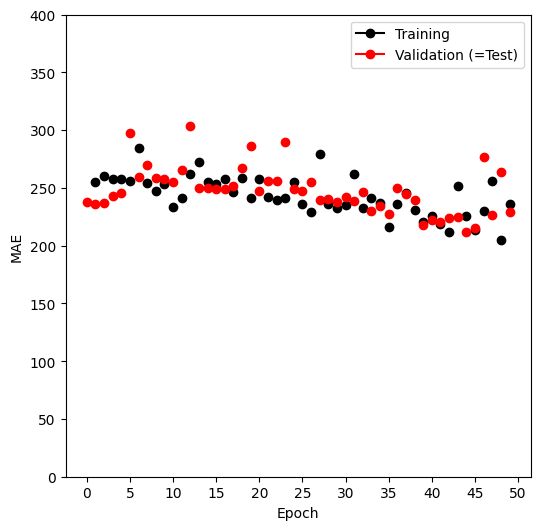

In [44]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

We can predict directly from the final model, and
evaluate its performance on the test data.
Before fitting, we call the `eval()` method
of `hit_model`.
This tells
`torch` to effectively consider this model to be fitted, so that
we can use it to predict on new data. For our model here,
the biggest change is that the dropout layers will
be turned off, i.e. no weights will be randomly
dropped in predicting on new data.

In [45]:
hit_model.eval()
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(229.5011, grad_fn=<MeanBackward0>)

### Cleanup
In setting up our data module, we had initiated
several worker processes that will remain running.
We delete all references to the torch objects to ensure these processes
will be killed.


In [46]:
del(Hitters,
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module)


## Multilayer Network on the MNIST Digit Data
The `torchvision` package comes with a number of example datasets,
including the `MNIST`  digit data. Our first step is to retrieve
the training and test data sets; the `MNIST()` function within
`torchvision.datasets` is provided for this purpose. The
data will be downloaded the first time this function is executed, and stored in the directory `data/MNIST`.

In [47]:
(mnist_train,
 mnist_test) = [MNIST(root='data',
                      train=train,
                      download=True,
                      transform=ToTensor())
                for train in [True, False]]
mnist_train


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 15.0MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.64MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.07MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

There are 60,000 images in the training data and 10,000 in the test
data. The images are $28\times 28$, and stored as a matrix of pixels. We
need to transform each one into a vector.

Neural networks are somewhat sensitive to the scale of the inputs, much as ridge and
lasso regularization are affected by scaling.  Here the inputs are eight-bit
grayscale values between 0 and 255, so we rescale to the unit
interval. {Note: eight bits means $2^8$, which equals 256. Since the convention
is to start at $0$, the possible values  range from $0$ to $255$.}
This transformation, along with some reordering
of the axes, is performed by the `ToTensor()` transform
from the `torchvision.transforms` package.

As in our `Hitters` example, we form a data module
from the training and test datasets, setting aside 20%
of the training images for validation.

In [48]:
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=256)


Let’s take a look at the data that will get fed into our network. We loop through the first few
chunks of the test dataset, breaking after 2 batches:

In [49]:
for idx, (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break


X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


We see that the $X$ for each batch consists of 256 images of size `1x28x28`.
Here the `1` indicates a single channel (greyscale). For RGB images such as `CIFAR100` below,
we will see that the `1` in the size will be replaced by `3` for the three RGB channels.

Now we are ready to specify our neural network.

In [50]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3))
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10))
    def forward(self, x):
        return self._forward(x)

We see that in the first layer, each `1x28x28` image is flattened, then mapped to
256 dimensions where we apply a ReLU activation with 40% dropout.
A second layer maps the first layer’s output down to
128 dimensions, applying a ReLU activation with 30% dropout. Finally,
the 128 dimensions are mapped down to 10, the number of classes in the
`MNIST`  data.

In [51]:
mnist_model = MNISTModel()


We can check that the model produces output of expected size based
on our existing batch `X_` above.

In [52]:
mnist_model(X_).size()

torch.Size([256, 10])

Let’s take a look at the summary of the model. Instead of an `input_size` we can pass
a tensor of correct shape. In this case, we pass through the final
batched `X_` from above.

In [53]:
summary(mnist_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

Having set up both  the model and the data module, fitting this model is
now almost identical to the `Hitters` example. In contrast to our regression model, here we will use the
`SimpleModule.classification()` method which
uses the  cross-entropy loss function instead of mean squared error. It must be supplied with the number of
classes in the problem.

In [54]:
mnist_module = SimpleModule.classification(mnist_model,
                                           num_classes=10)
mnist_logger = CSVLogger('logs', name='MNIST')


Now we are ready to go. The final step is to supply training data, and fit the model.

In [55]:
mnist_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=mnist_logger,
                        callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,
                  datamodule=mnist_dm)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | MNISTModel       | 235 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


We have suppressed the output here, which is a progress report on the
fitting of the model, grouped by epoch. This is very useful, since on
large datasets fitting can take time. Fitting this model took 245
seconds on a MacBook Pro with an Apple M1 Pro chip with 10 cores and 16 GB of RAM.
Here we specified a
validation split of 20%, so training is actually performed on
80% of the 60,000 observations in the training set. This is an
alternative to actually supplying validation data, like we did for the `Hitters` data.
SGD  uses batches
of 256 observations in computing the gradient, and doing the
arithmetic, we see that an epoch corresponds to 188 gradient steps.

`SimpleModule.classification()` includes
an accuracy metric by default. Other
classification metrics can be added from `torchmetrics`.
We will use  our `summary_plot()` function to display
accuracy across epochs.

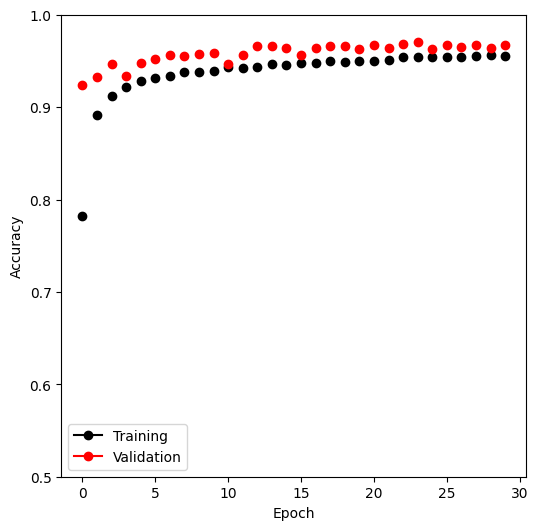

In [ ]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int));


Once again we evaluate the accuracy using the `test()` method of our trainer. This model achieves
97% accuracy on the test data.

In [ ]:
mnist_trainer.test(mnist_module,
                   datamodule=mnist_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9656999707221985
        test_loss           0.15191325545310974
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.15191325545310974, 'test_accuracy': 0.9656999707221985}]

Table 10.1 also reports the error rates resulting from LDA (Chapter 4) and multiclass logistic
regression. For LDA we refer the reader to Section 4.7.3.
Although we could use the `sklearn` function `LogisticRegression()` to fit  
multiclass logistic regression, we are set up here to fit such a model
with `torch`.
We just have an input layer and an output layer, and omit the hidden layers!

In [ ]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 10))
    def forward(self, x):
        return self.linear(x)

mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model,
                                         num_classes=10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

In [ ]:
mlr_trainer = Trainer(deterministic=True,
                      max_epochs=30,
                      callbacks=[ErrorTracker()])
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jonathantaylor/anaconda3/envs/isolated_env_1eb44da1_Ch10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNIST_MLR        | 7.9 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
7.9 K     Trainable params
0      

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


We fit the model just as before and compute the test results.

In [ ]:
mlr_trainer.test(mlr_module,
                 datamodule=mnist_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9235000014305115
        test_loss           0.3271547853946686
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3271547853946686, 'test_accuracy': 0.9235000014305115}]

The accuracy is above 90% even for this pretty simple model.

As in the `Hitters` example, we delete some of
the objects we created above.

In [ ]:
del(mnist_test,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer)